#  Y = 3 vs all

# checkpoint 1

In [ ]:
YEQUALS = 3

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
import warnings
warnings.filterwarnings("ignore")
# install libraries
from sklearn.model_selection import train_test_split
import os
! pwd
import sys
sys.path.append('../Library')

from data_prep import PreProcessor1

import library_leo as leo



/Users/leonardodicaterina/Documents/GitHub/Machine_Learning_G19/Notebooks


In [27]:
train_path = "../Data/train_data_mok.csv"
test_path = "../Data/test_data_mok.csv"
# Replace 'Column29' with the actual column name that has mixed types
dtype = {'Column29': 'str'}

train = pd.read_csv(train_path, dtype=dtype,index_col='Claim Identifier')
dtest = pd.read_csv(test_path, dtype=dtype,index_col='Claim Identifier')

In [28]:
train = train.dropna(subset=['Claim Injury Type'])
y = train['Claim Injury Type']
train = train.drop(columns=['Claim Injury Type'])
y_str = y.str[:1]
y_int = y_str.astype(int)
# make Y_int 1 if it's equal to YEQUALS else 0
y_int = y_int.apply(lambda x: 1 if x == YEQUALS else 0)

In [29]:
# partition the data X, y and y_2bin
X_train, X_valid, y_train,y_valid = train_test_split(
    train, y_int, test_size=0.2, random_state=0)

In [30]:
y_train.value_counts()

Claim Injury Type
1    384
0    383
Name: count, dtype: int64

In [31]:
pr = PreProcessor1()
print("------------updates---------------------")
pr.update_casted_cols()
print("------------set_casting---------------------")
pr.set_castings(X_train)
print("------------pipeline---------------------")
df_train = pr.cast_pipeline(X_train)
print("df after cast_pipeline:", df_train.shape)
print("------------fillna---------------------")
pr.update_fillna_list(df_train)   
df_train = pr.fillna_pipeline(df_train)
print("df after fillna_pipeline:", df_train.shape)
print("------------transformation---------------------")
pr.set_transformations(df_train)
pr.append_transformation('Carrier Name','freq_encode','fe_Carrier Name')
df_train = pr.transformation_pipeline(df_train)
print("df after transformation_pipeline:", df_train.shape)
df_train= pr.scaling_pipeline(df_train)
df_train = df_train.drop(columns=['Agreement Reached', 'WCB Decision'])
df_train.info() 

------------updates---------------------
------------set_casting---------------------
Columns that are not casted:
-WCB Decision: object
------------pipeline---------------------
Feature Carrier Type is already in scaling list
Feature Zip Code is already in scaling list
'Industry Code Description'
-Column Industry Code Description not found
df after cast_pipeline: (767, 26)
------------fillna---------------------
extended fillna_list: [('Age at Injury', 'median'), ('Average Weekly Wage', 'median'), ('Birth Year', 'median'), ('IME-4 Count', 'median'), ('Industry Code', 'median'), ('WCIO Cause of Injury Code', 'median'), ('WCIO Nature of Injury Code', 'median'), ('WCIO Part Of Body Code', 'median'), ('Zip Code', 'median'), ('Agreement Reached', 'median'), ('Number of Dependents', 'median'), ('Accident Date', 'mode'), ('Alternative Dispute Resolution', 'mode'), ('Assembly Date', 'mode'), ('Attorney/Representative', 'mode'), ('C-2 Date', 'mode'), ('C-3 Date', 'mode'), ('Carrier Name', 'mod

In [32]:
pr.update_status('valid')
print("------------updates---------------------")
pr.update_casted_cols()
print("------------set_casting---------------------")
pr.set_castings(X_valid)
print("------------pipeline---------------------")
df_valid = pr.cast_pipeline(X_valid)
print("df after cast_pipeline:", df_valid.shape)
print("------------fillna---------------------")
pr.update_fillna_list(df_valid)   
df_valid = pr.fillna_pipeline(df_valid)
print("df after fillna_pipeline:", df_valid.shape)
print("------------transformation---------------------")
pr.set_transformations(df_valid)
df_valid = pr.transformation_pipeline(df_valid)
print("df after transformation_pipeline:", df_valid.shape)
df_valid = pr.scaling_pipeline(df_valid)
df_valid = df_valid.drop(columns=['Agreement Reached', 'WCB Decision'])

df_valid.info()

------------updates---------------------
------------set_casting---------------------
Columns that are not casted:
-WCB Decision: object
------------pipeline---------------------
Feature Carrier Type is already in scaling list
Feature Zip Code is already in scaling list
'Industry Code Description'
-Column Industry Code Description not found
"['Industry Code Description'] not found in axis"
-Column Industry Code Description not found
"['OIICS Nature of Injury Description'] not found in axis"
-Column OIICS Nature of Injury Description not found
"['WCIO Cause of Injury Description'] not found in axis"
-Column WCIO Cause of Injury Description not found
"['WCIO Nature of Injury Description'] not found in axis"
-Column WCIO Nature of Injury Description not found
"['WCIO Part Of Body Description'] not found in axis"
-Column WCIO Part Of Body Description not found
'Industry Code Description'
-Column Industry Code Description not found
df after cast_pipeline: (192, 26)
------------fillna-------

## feature selection

In [33]:
num_features = df_train.select_dtypes(include=[np.number]).columns
obj_features = df_train.select_dtypes(include=[object,'string']).columns


In [34]:
obj_features

Index(['Carrier Name', 'Carrier Type', 'County of Injury', 'District Name',
       'Gender', 'Medical Fee Region'],
      dtype='object')

### correlation with target

#### Linear correlation


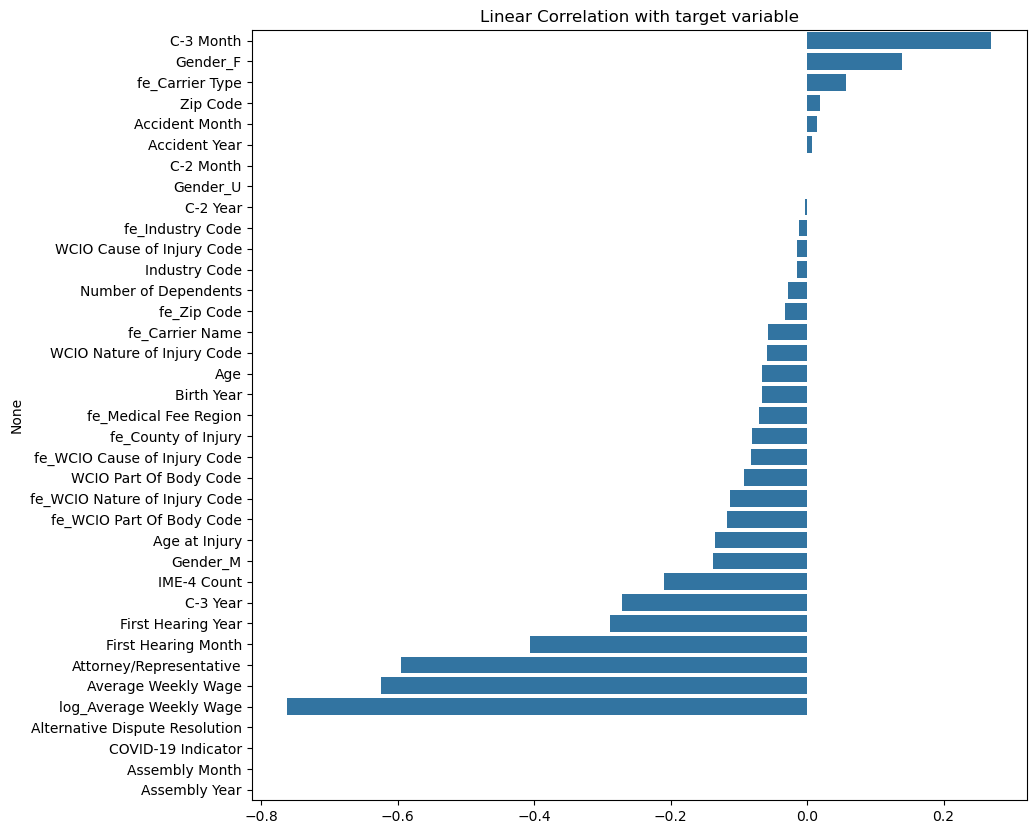

In [35]:
corr_y = df_train[num_features].corrwith(y_train)
corr_y = corr_y.sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=corr_y.values, y=corr_y.index)
plt.title('Linear Correlation with target variable')

plt.show()

#### entropy correlation

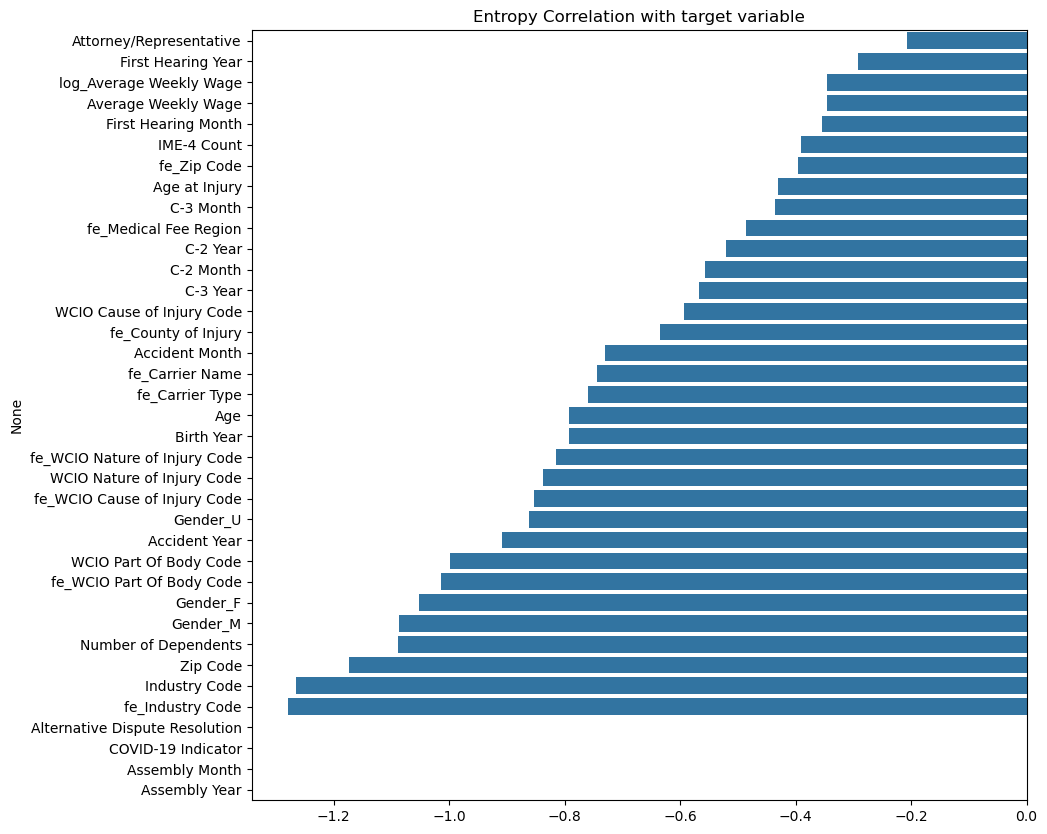

In [36]:
s_corr_y = []
for col in num_features:
    s_col = leo.two_col_entropy_corr(df_train[col], y_train)
    s_col = log((s_col +1)/2)
    s_corr_y.append(s_col)
    
s_corr_y = pd.Series(s_corr_y, index=num_features).sort_values(ascending=False)
s_corr_y = s_corr_y.sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=s_corr_y.values, y=s_corr_y.index)
plt.title('Entropy Correlation with target variable')
plt.show()  

#### chi2 correlation for categorical features

In [37]:
from scipy.stats import chi2_contingency

Text(0.5, 0, 'x')

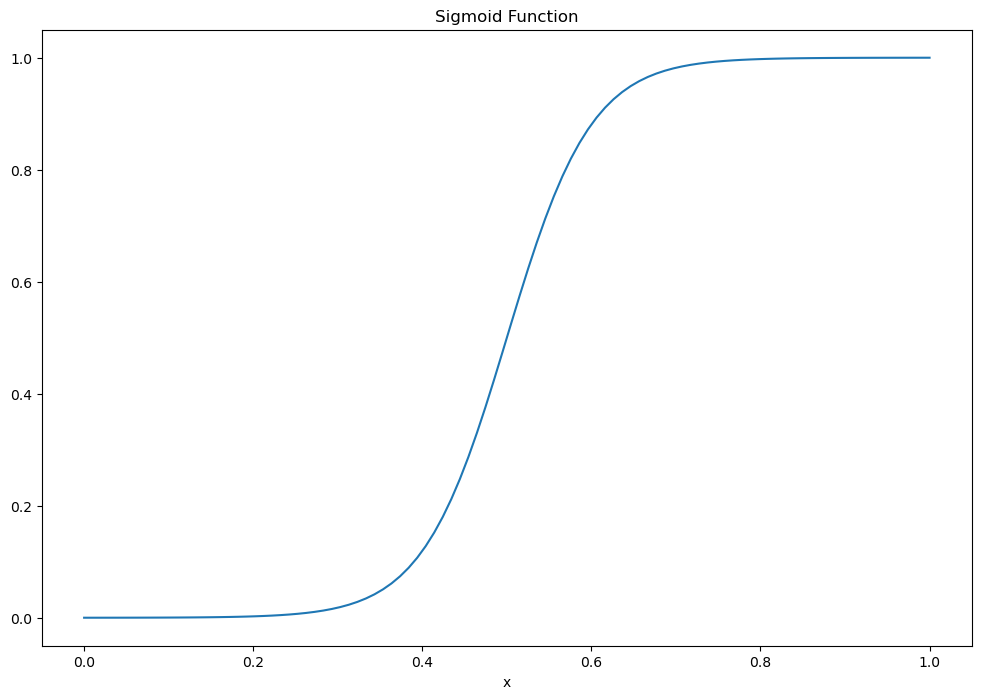

In [38]:
def sigmoid(x, a=20):
    return 1 / (1 + np.exp(-a * (x - 0.5)))

plt.figure(figsize=(12, 8))
x = np.linspace(0, 1, 100)
y = sigmoid(x)
plt.plot(x, y)
plt.title('Sigmoid Function')
plt.xlabel('x')

In [39]:
def chi2_feature_importance(f1, target, significance_level=0.05, log=False):
    """
    Evaluate if a feature is important to predict the target using the Chi-squared test.

    Parameters:
        data (pd.DataFrame): The dataset containing the feature and target.
        feature (str): The name of the feature column.
        target (str): The name of the target column.
        significance_level (float): The threshold for statistical significance (default 0.05).

    Returns:
        dict: A dictionary containing the chi-squared statistic, p-value, and whether the feature is important.
    """
    # Create a contingency table
    contingency_table = pd.crosstab(f1, target)

    # Perform the Chi-squared test
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

    total_observations = contingency_table.sum().sum()
    rows, cols = contingency_table.shape

    cramers_v = np.sqrt(
        chi2_stat / (total_observations * min(cols - 1, rows - 1)))

    is_important = p_value < significance_level

    if log:
        if cramers_v < 0.3:
            print(f" {is_important} the test is not significant {cramers_v}")
        elif cramers_v < 0.5:
            print(f" {is_important} the test is weakly significant {cramers_v}")
        elif cramers_v < 0.7:
            print(f" {is_important} the test is moderately significant {cramers_v}")
        elif cramers_v < 1:
            print(f" {is_important} the test is highly significant {cramers_v}")
        else:
            print(f"the test has no sense {cramers_v}")

    # Determine if the feature is important
    is_important = p_value < significance_level
    return cramers_v, p_value

In [40]:
df_train[col]

Claim Identifier
5394068   -0.157895
5394838   -0.157895
5393780    0.184211
5393860    0.184211
5394440   -0.105263
             ...   
5394900   -0.210526
5394590    4.421053
5394571    4.421053
5394652    4.421053
5394512   -0.184211
Name: fe_Carrier Name, Length: 767, dtype: float64

Feature: Carrier Name
 True the test is moderately significant 0.6179278949248005
normalized score: 0.912700597211183
--------------------------------------------------
Feature: Carrier Type
 True the test is not significant 0.11847330584629756
normalized score: 0.00047093663466093023
--------------------------------------------------
Feature: County of Injury
 False the test is weakly significant 0.30528293266239387
normalized score: 0.017011233839621574
--------------------------------------------------
Feature: District Name
 False the test is not significant 0.12399502843310585
normalized score: 0.00048349199077860647
--------------------------------------------------
Feature: Gender
 True the test is not significant 0.13875555118101524
normalized score: 0.0007272512661496889
--------------------------------------------------
Feature: Medical Fee Region
 True the test is not significant 0.1144642854343773
normalized score: 0.0004300653546615812
-------------------------------------

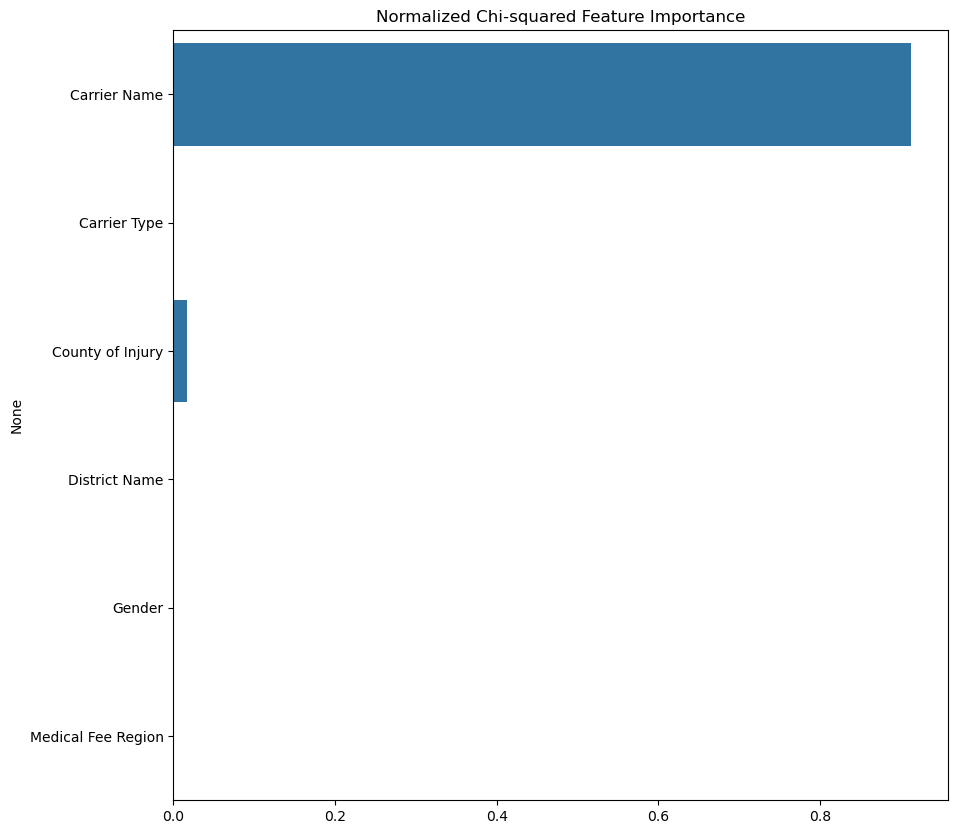

In [41]:
normalized_scores = []
 
for col in obj_features:
    print(f"Feature: {col}")
    cramers_v, p_value = chi2_feature_importance(df_train[col], y_train, log=True)
    normalized_scores.append((1 - p_value)*sigmoid(cramers_v))
    print(f'normalized score: {normalized_scores[-1]}')
    print("-"*50)

plt.figure(figsize=(10, 10))
sns.barplot(x=normalized_scores, y=obj_features)
plt.title('Normalized Chi-squared Feature Importance')
plt.show()

#### best features level 1

In [42]:
best_lin = list((corr_y [corr_y.abs() > 0.3]).index)
best_ent = list((s_corr_y [s_corr_y > - 0.4]).index)
best_chi2 = list((pd.Series(normalized_scores, index=obj_features)[pd.Series(normalized_scores, index=obj_features) > 0.5]).index)

In [43]:
bestnum = set(best_lin + best_ent)
bestnum = list(bestnum)
bestnum.append('fe_Carrier Name')
bestnum

['Average Weekly Wage',
 'First Hearing Month',
 'log_Average Weekly Wage',
 'IME-4 Count',
 'First Hearing Year',
 'fe_Zip Code',
 'Attorney/Representative',
 'fe_Carrier Name']

In [44]:
best_chi2

['Carrier Name']

### correlation between features

#### Linear correlation

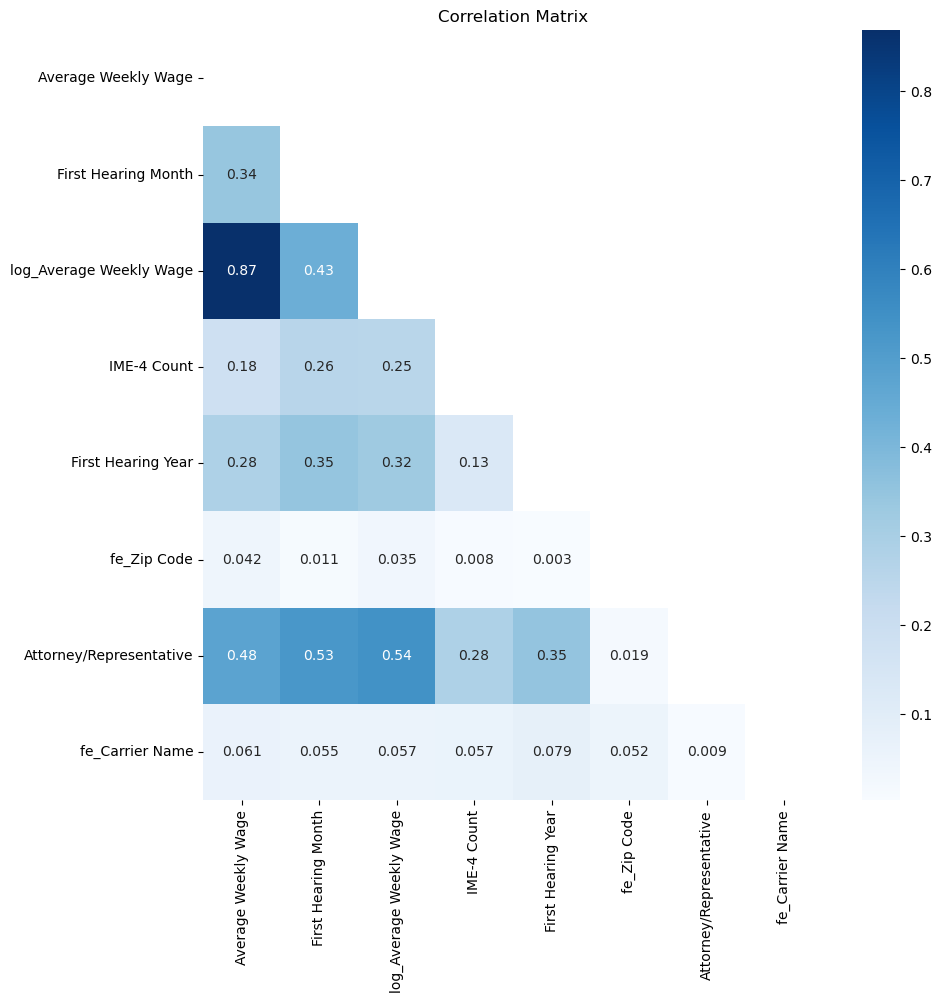

In [45]:
# correlation between numerical features
corr = df_train[bestnum].corr()
#half of the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
sns.heatmap(np.abs(corr), annot=True, cmap='Blues', mask=mask)
plt.title('Correlation Matrix')
plt.show()


#### entropy correlation

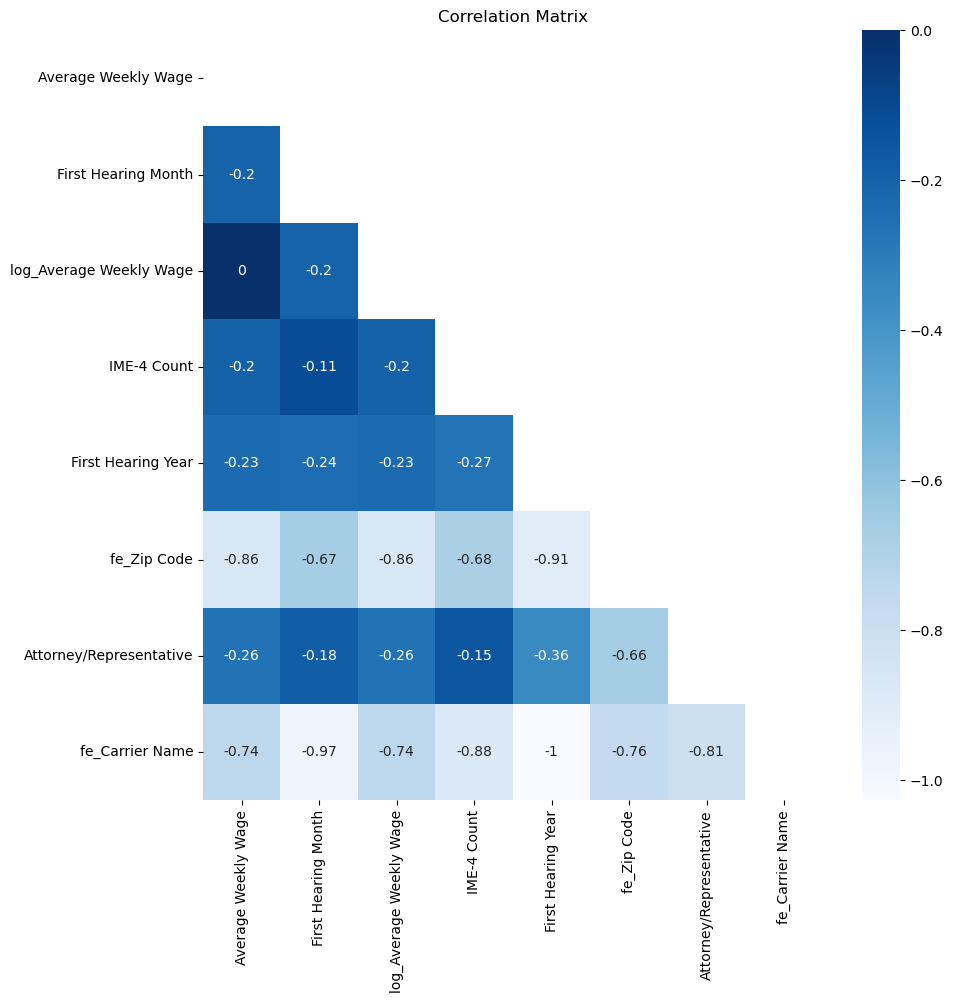

In [46]:
s_corr = leo.entropy_corr(df_train[bestnum])
#half of the matrix
mask = np.zeros_like(s_corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
sns.heatmap(s_corr, annot=True, cmap='Blues', mask=mask)
plt.title('Correlation Matrix')
plt.show()

#### best featues level 2


In [ ]:
bestnum = ['C-2 Month',
 'fe_Zip Code',
 'Accident Month',
 'Accident Year',
 'fe_WCIO Nature of Injury Code',
 'Gender_F']

In [48]:
df_train['Carrier Name'].value_counts()

Carrier Name
STATE INSURANCE FUND             177
INDEMNITY INS. OF N AMERICA       40
POLICE, FIRE, SANITATION          31
CHARTER OAK FIRE INS CO           22
NEW HAMPSHIRE INSURANCE CO        16
                                ... 
TRANS PACIFIC INSURANCE CO         1
MONTICELLO CENTRAL                 1
NEW YORK CITY TRANSIT AUTH         1
STATE NATIONAL INSURANCE           1
TOKIO MARINE AMERICA INS. CO.      1
Name: count, Length: 223, dtype: Int64

# checkpoint 2

In [74]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier  # Import for ANN
# import the naive bayes module
from sklearn.naive_bayes import GaussianNB


## smote and tomek

In [50]:
df_train_np = df_train[bestnum].to_numpy()
y_train_np = y_train.to_numpy(dtype=int)

In [51]:

smote_tomek = SMOTETomek(sampling_strategy='auto')

# Ensure y_train contains integer values
y_train_int = y_train.round().astype('float64').to_numpy()
# Assuming you have your feature matrix X and target variable y
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(df_train_np, y_train_np)
df_train_resampled = pd.DataFrame(X_train_resampled, columns=bestnum)
y_train_resampled = pd.Series(y_train_resampled)

#smote = SMOTE(sampling_strategy='minority', random_state=42)

print("Resampling completed successfully!")

Resampling completed successfully!


In [52]:
y_train_resampled.value_counts()

0    375
1    375
Name: count, dtype: int64

## multiple model training

In [81]:
# make grid search validation for every model in the list model_list_num
model_list_num = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), HistGradientBoostingClassifier()]

X_train_resampled_small, X_train_resampled_big, y_train_resampled_small, y_train_resampled_big = train_test_split(X_train_resampled, y_train_resampled, test_size=0.8, random_state=42,stratify=y_train_resampled)

model_list_num = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    HistGradientBoostingClassifier(),
    SVC(),  # Add SVC for Support Vector Machine
    MLPClassifier(),  # Add MLPClassifier for ANN
    GaussianNB()
]

model_names = [
    'LogisticRegression',
    'DecisionTreeClassifier',
    'RandomForestClassifier',
    'HistGradientBoostingClassifier',
    'SVC',
    'MLPClassifier',
    'GaussianNB'
]


best_params = []

param_grid_logistc = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

param_grid_tree = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_hgb = {
    'max_iter': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10]
}

param_grid_svc = {
    'C': [0.1, 1, 10],  # Common hyperparameters for SVC
    'kernel': ['linear', 'rbf'],  # Try different kernels
}

param_grid_mlp = {  # Hyperparameters for ANN (MLPClassifier)
    'hidden_layer_sizes': [(100,), (100, 50), (100, 100)],  # Different hidden layer configurations
    'activation': ['relu', 'tanh'],  # Experiment with activation functions
    'solver': ['adam', 'lbfgs']  # Choose a suitable solver
}

param_grid_gnb = {  } # GaussianNB has no hyperparameters to tune
param_list = [param_grid_logistc, param_grid_tree, param_grid_rf, param_grid_hgb, param_grid_svc, param_grid_mlp, param_grid_gnb]
best_params = []

for model, param_grid in zip(model_list_num, param_list):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_resampled_small, y_train_resampled_small)
    best_params.append(grid_search.best_params_)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")



Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.9094028520499109
Best parameters: {'max_depth': 10, 'min_samples_split': 2}
Best score: 0.8810653293575494
Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.9143939393939394
Best parameters: {'max_depth': 5, 'max_iter': 100, 'min_samples_leaf': 10}
Best score: 0.9
Best parameters: {'C': 10, 'kernel': 'linear'}
Best score: 0.8960483210483211


/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}
Best score: 0.9094028520499109
Best parameters: {}
Best score: 0.9066229179843981


/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to conv

In [82]:
num_features_to_run = bestnum

tn_list = []
fp_list = []
fn_list = []
tp_list = []

for model, param in zip (model_list_num, best_params):
    model.set_params(**param)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(df_valid[bestnum])
    print(f"Model: {model}")
    acc = accuracy_score(y_valid, y_pred)
    print(f"Accuracy: \n{acc}")
    print(f"Precision: \n{precision_score(y_valid, y_pred)}")
    print(f"Recall: \n{recall_score(y_valid, y_pred)}")
    print(f"F1: \n{f1_score(y_valid, y_pred)}")
    print(f"ROC AUC: \n{roc_auc_score(y_valid, y_pred)}")
    print(f"Confusion Matrix: \n{confusion_matrix(y_valid, y_pred)}")
    print("-"*50)
    cm = confusion_matrix(y_valid, y_pred, normalize='pred')
    tn, fp, fn, tp = cm.ravel()
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    tp_list.append(tp)
    num = int(acc*100)
    #leo.report_and_save(model= model,
    #                    model_name = f"{YEQUALS}_{num}_model_{model_names[model_list_num.index(model)]}",
    #                    y_pred = y_pred,
    #                    y = y_valid,
    #                    feature_list = num_features_to_run)

Model: LogisticRegression(C=10, penalty='l1', solver='liblinear')
Accuracy: 
0.890625
Precision: 
0.8936170212765957
Recall: 
0.8842105263157894
F1: 
0.8888888888888888
ROC AUC: 
0.8905588714053175
Confusion Matrix: 
[[87 10]
 [11 84]]
--------------------------------------------------
Model: DecisionTreeClassifier(max_depth=10)
Accuracy: 
0.703125
Precision: 
0.9130434782608695
Recall: 
0.4421052631578947
F1: 
0.5957446808510638
ROC AUC: 
0.7004340748779165
Confusion Matrix: 
[[93  4]
 [53 42]]
--------------------------------------------------
Model: RandomForestClassifier(max_depth=5)
Accuracy: 
0.5833333333333334
Precision: 
0.9411764705882353
Recall: 
0.16842105263157894
F1: 
0.2857142857142857
ROC AUC: 
0.5790558871405319
Confusion Matrix: 
[[96  1]
 [79 16]]
--------------------------------------------------
Model: HistGradientBoostingClassifier(max_depth=5, min_samples_leaf=10)
Accuracy: 
0.59375
Precision: 
0.9473684210526315
Recall: 
0.18947368421052632
F1: 
0.315789473684210

In [83]:
y_train_resampled_4_xgb = y_train_resampled
y_valid_4_xgb = y_valid


dtrain = xgb.DMatrix(df_train_resampled, label=y_train_resampled_4_xgb)
dvalid = xgb.DMatrix(df_valid[num_features_to_run], label=y_valid_4_xgb)

# run a grid search for param_xgb
param_xgb = {
    'max_depth': [3, 5, 7],
    'eta': [0.1, 0.3, 0.5],
    'objective': ['binary:logistic']
}

grid = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_xgb, cv=5, n_jobs=-1)
grid.fit(df_train_resampled, y_train_resampled_4_xgb)
print(grid.best_params_)

best_params_xgb = grid.best_params_

model_xgb = xgb.XGBClassifier(**best_params_xgb)
model_xgb.fit(df_train_resampled, y_train_resampled_4_xgb)
y_pred_xgb = model_xgb.predict(df_valid[num_features_to_run])
acc = accuracy_score(y_valid_4_xgb, y_pred_xgb)
print(f"Accuracy: \n{acc}")
print(f"Precision: \n{precision_score(y_valid_4_xgb, y_pred_xgb)}")
print(f"Recall: \n{recall_score(y_valid_4_xgb, y_pred_xgb)}")
print(f"F1: \n{f1_score(y_valid_4_xgb, y_pred_xgb)}")
print(f"ROC AUC: \n{roc_auc_score(y_valid_4_xgb, y_pred_xgb)}")
print(f"Confusion Matrix: \n{confusion_matrix(y_valid_4_xgb, y_pred_xgb)}")
acc = int(acc*100)

#leo.report_and_save(model= model_xgb,
#                    y_pred = y_pred_xgb,
#                    y = y_valid_4_xgb,
#                    model_name = f"{YEQUALS}_{acc}_model_XGBClassifier",
#                    feature_list = num_features_to_run)

model_names.append('XGBClassifier')
model_list_num.append(model_xgb)
tn, fp, fn, tp = confusion_matrix(y_valid_4_xgb, y_pred_xgb, normalize='pred').ravel()
tn_list.append(tn)
fp_list.append(fp)
fn_list.append(fn)
tp_list.append(tp)



{'eta': 0.1, 'max_depth': 3, 'objective': 'binary:logistic'}
Accuracy: 
0.5260416666666666
Precision: 
1.0
Recall: 
0.042105263157894736
F1: 
0.08080808080808081
ROC AUC: 
0.5210526315789473
Confusion Matrix: 
[[97  0]
 [91  4]]


In [84]:
y_train_resampled_4_lightgbm = y_train_resampled
y_valid_4_lightbm = y_valid

param_lightgbm = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.3, 0.5],
    'objective': ['binary']
}

grid = GridSearchCV(estimator=lightgbm.LGBMClassifier(), param_grid=param_lightgbm, cv=5, n_jobs=-1)
grid.fit(df_train_resampled, y_train_resampled_4_lightgbm)
print(grid.best_params_)
best_params_lightgbm = grid.best_params_

model_lightgbm = lightgbm.LGBMClassifier(**best_params_lightgbm)
model_lightgbm.fit(df_train_resampled, y_train_resampled_4_lightgbm)
y_pred_lightgbm = model_lightgbm.predict(df_valid[num_features_to_run])
acc = accuracy_score(y_valid_4_lightbm, y_pred_lightgbm)
print(f"Accuracy: \n{acc}")
print(f"Precision: \n{precision_score(y_valid_4_lightbm, y_pred_lightgbm)}")
print(f"Recall: \n{recall_score(y_valid_4_lightbm, y_pred_lightgbm)}")
print(f"F1: \n{f1_score(y_valid_4_lightbm, y_pred_lightgbm)}")
print(f"ROC AUC: \n{roc_auc_score(y_valid_4_lightbm, y_pred_lightgbm)}")
print(f"Confusion Matrix: \n{confusion_matrix(y_valid_4_lightbm, y_pred_lightgbm)}")
acc = int(acc*100)

#leo.report_and_save(model= model_lightgbm,
#                    y_pred = y_pred_lightgbm,
#                    y = y_valid_4_lightbm,
#                    model_name = f"{YEQUALS}_{acc}_model_LGBMClassifier",
#                    feature_list = num_features_to_run)

model_names.append('lightgbm')
model_list_num.append(model_lightgbm)

tn, fp, fn, tp = confusion_matrix(y_valid_4_lightbm, y_pred_lightgbm, normalize='pred').ravel()
tn_list.append(tn)
fp_list.append(fp)
fn_list.append(fn)
tp_list.append(tp)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 300, number of negative: 300
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 300, number of negative: 300
[LightGBM] [Info] Number of positive: 300, number of negative: 300
[LightGBM] [Warning] Found whitespace in feature_names, 

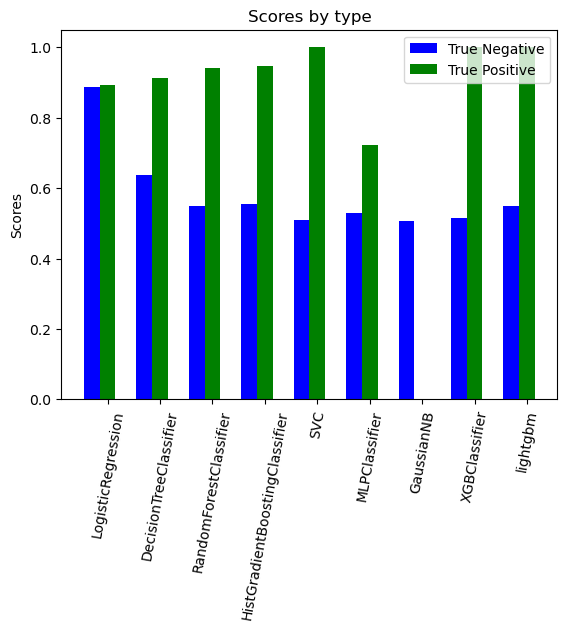

In [85]:
fig, ax = plt.subplots()
width = 0.3 # width of bar
x = np.arange(len(model_names))
ax.bar(x, tn_list, width, color='b', label='True Negative')
ax.bar(x + width, tp_list, width, color='g', label='True Positive')
# rotate the tick labels for better visibility
ax.set_xticklabels(model_names, rotation = 80)
ax.set_ylabel('Scores')
ax.set_title('Scores by type')

ax.set_xticks(x + width)
ax.set_xticklabels(model_names)
ax.legend()
plt.show()

In [86]:
tn_list

[np.float64(0.8877551020408163),
 np.float64(0.636986301369863),
 np.float64(0.5485714285714286),
 np.float64(0.5549132947976878),
 np.float64(0.5105263157894737),
 np.float64(0.5287356321839081),
 np.float64(0.5052083333333334),
 np.float64(0.5159574468085106),
 np.float64(0.5480225988700564)]

# checkpoint 3

## recursive feature elimination

# checkpoint 4